In [6]:
import numpy as np
import torch
from utils import mostra_sumario, plota_graficos
import pickle
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#Verificando se há pastas no diretório de dados sem imagens
import os
count_empty_folders = 0
count_empty_folders_class0 = 0
count_empty_folders_class1 = 0
for id_folder in os.listdir('../MLChallenge_Dataset/Data'):
    id_folder_path = os.path.join('../MLChallenge_Dataset/Data', id_folder)
    if os.path.isdir(id_folder_path):
        for class_folder in os.listdir(id_folder_path):
            class_folder_path = os.path.join(id_folder_path, class_folder)
            if os.path.isdir(class_folder_path): #verify if it is a folder
                if len(os.listdir(class_folder_path)) == 0:
                    count_empty_folders += 1
                    if class_folder == 'live':
                        count_empty_folders_class1 += 1 
                    else:
                        count_empty_folders_class0 += 1                     

                    # print('Pasta {} vazia'.format(class_folder_path))
print('Total de pastas vazias: {}'.format(count_empty_folders))
print(f"Pastas vazias da classe spoof (0): {count_empty_folders_class0}")
print(f"Pastas vazias da classe live (1): {count_empty_folders_class1}")

Total de pastas vazias: 4910
Pastas vazias da classe spoof (0): 1296
Pastas vazias da classe live (1): 3614


## Carregando os dados utilizando o custom Dataset

### Verificando class imbalance no dataset

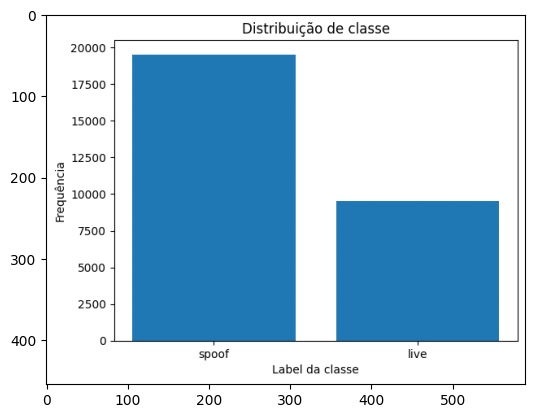

Class ratio: Spoof: 66% - Live: 33%


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('output/data_imbalance.png')
imgplot = plt.imshow(img)
plt.show()
print("Class ratio: Spoof: 66% - Live: 33%")

## Testando o modelo

In [7]:
foldperf = pickle.load(open('output/foldperf.pkl', 'rb'))
foldperf_balanced = pickle.load(open('output/foldperf_balanced.pkl', 'rb'))

print(f"Sumário da ResNet sem balanceamento de dados")
mostra_sumario(foldperf)

print("\n==========================================================================================================================\n")

print(f"Sumário da ResNet com balanceamento de dados")
mostra_sumario(foldperf_balanced)

Sumário da ResNet sem balanceamento de dados
Performance do 5 fold cross validation
Average Training Loss: 0.023 	 Average Test Loss: 0.043 	 Average Training Acc: 99.24 	 Average Test Acc: 98.56
Training Precision: 99.239 	 Test Precision: 98.634 	 Training Recall: 99.24 	 Test Recall: 98.56
Training F1: 99.239 	 Test F1: 98.562


Sumário da ResNet com balanceamento de dados
Performance do 5 fold cross validation
Average Training Loss: 0.023 	 Average Test Loss: 0.015 	 Average Training Acc: 99.24 	 Average Test Acc: 99.52
Training Precision: 99.243 	 Test Precision: 99.527 	 Training Recall: 99.24 	 Test Recall: 99.52
Training F1: 99.243 	 Test F1: 99.518


Gráficos da ResNet sem balanceamento de dados


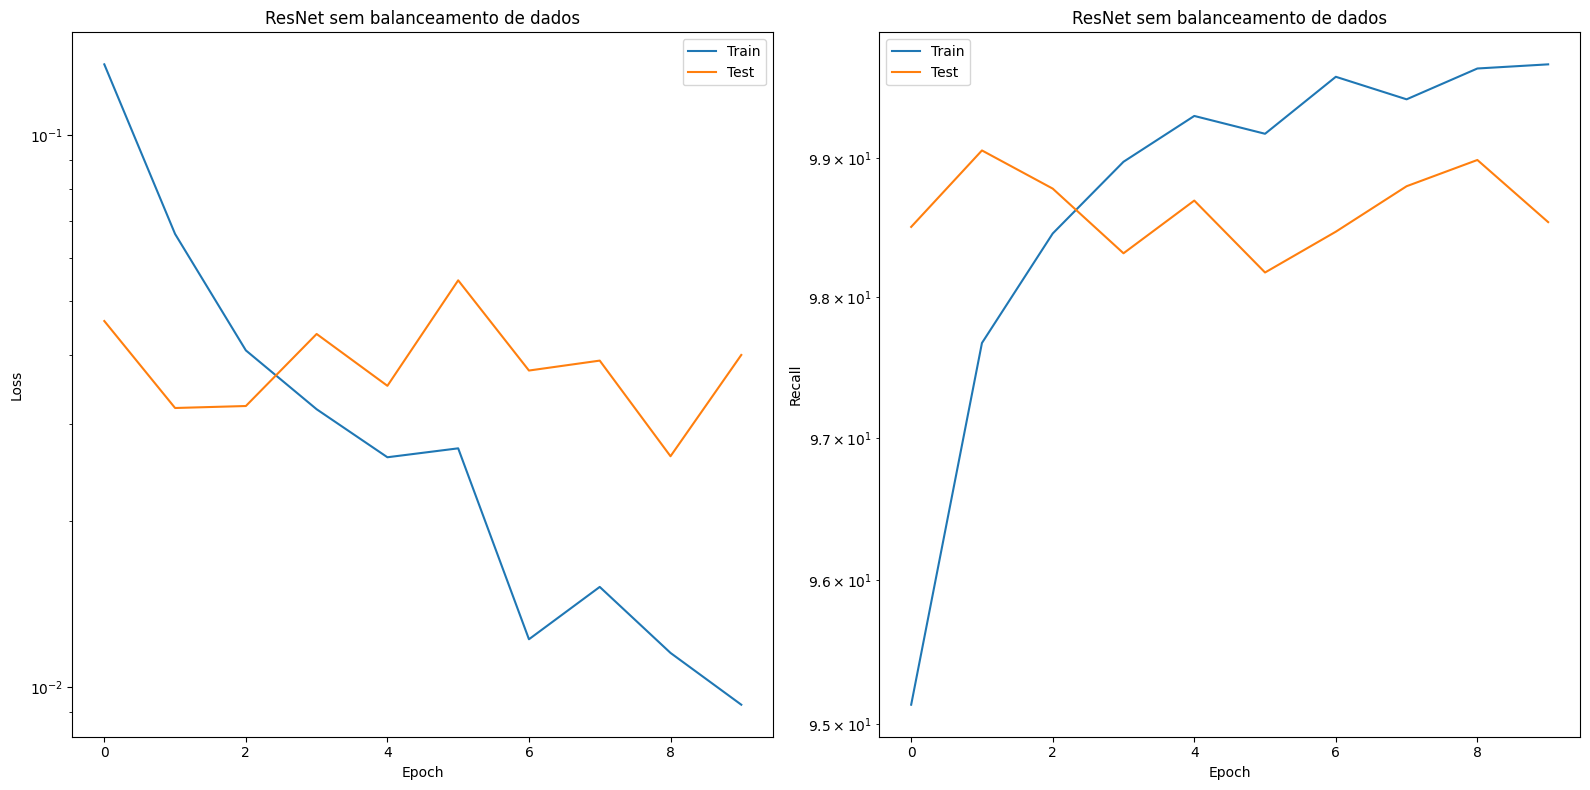



Gráficos da ResNet com balanceamento de dados


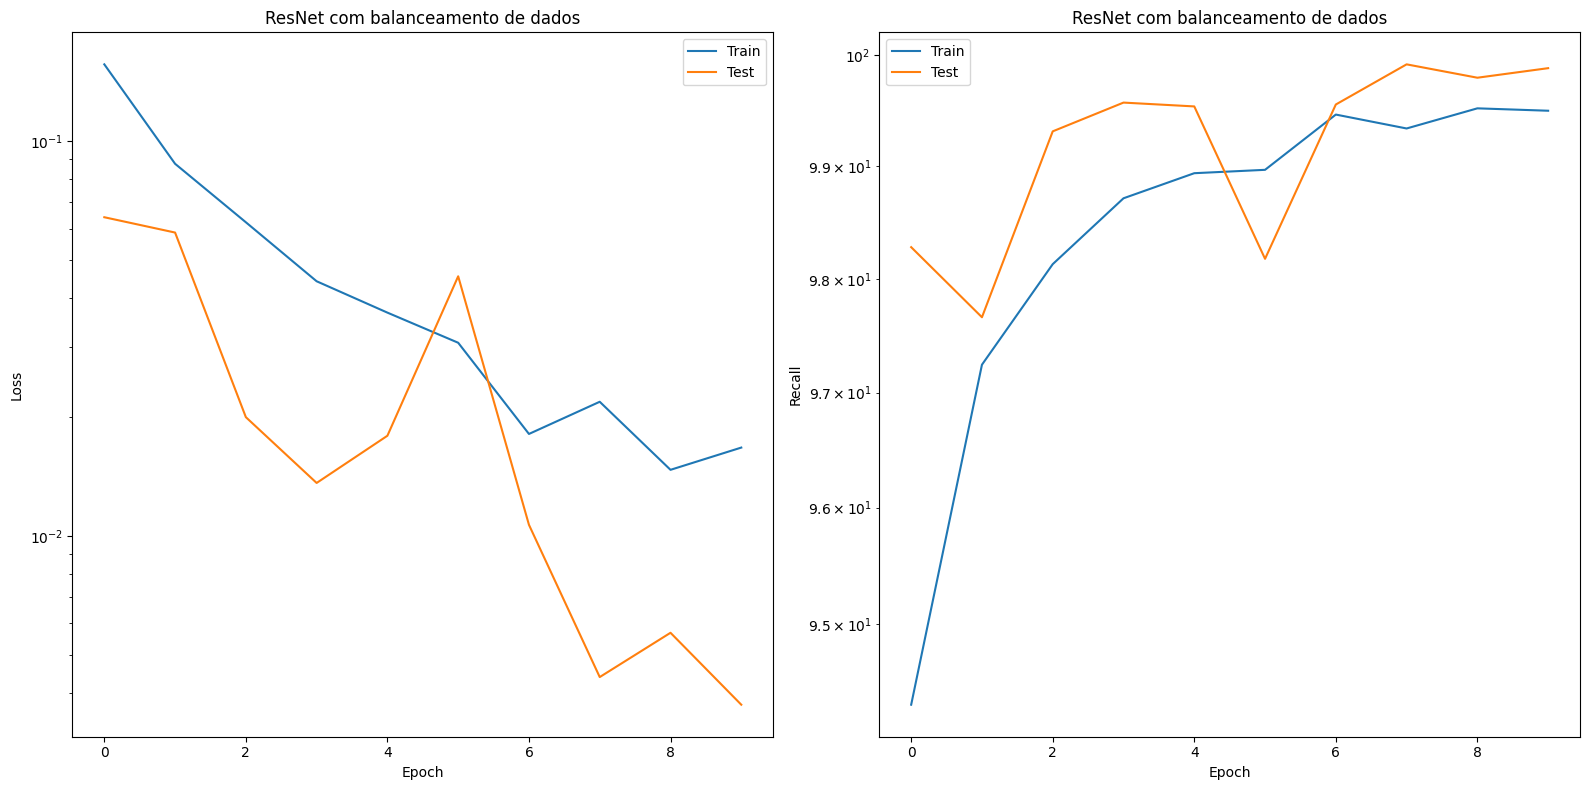

In [8]:
print(f"Gráficos da ResNet sem balanceamento de dados")
plota_graficos(foldperf, title='ResNet sem balanceamento de dados')

print("\n==========================================================================================================================\n")

print(f"Gráficos da ResNet com balanceamento de dados")
plota_graficos(foldperf_balanced, title='ResNet com balanceamento de dados')

/home/grad/si/13/paulohdscoelho/miniconda3/envs/most_ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/grad/si/13/paulohdscoelho/miniconda3/envs/most_ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


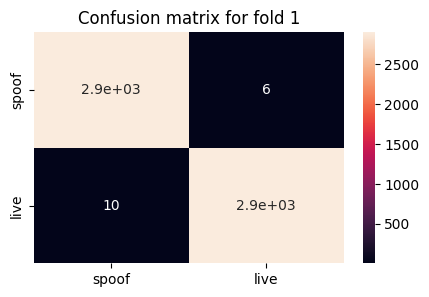

Matthews correlation coefficient for fold 1: 1


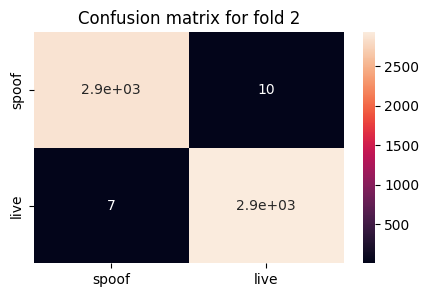

Matthews correlation coefficient for fold 2: 1


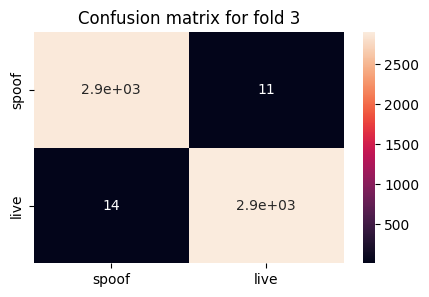

Matthews correlation coefficient for fold 3: 1


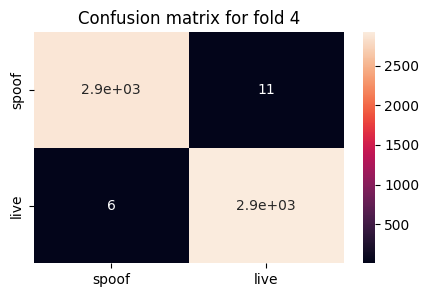

Matthews correlation coefficient for fold 4: 1


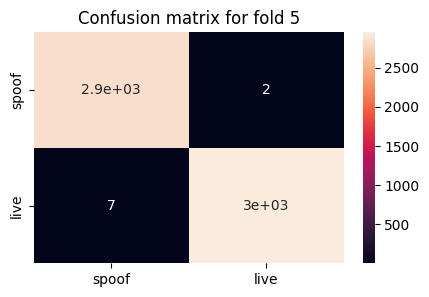

Matthews correlation coefficient for fold 5: 1


In [26]:
#print confusion matrix for each fold
import seaborn as sn
import matplotlib.pyplot as plt
from model import ResNet_pt
from sklearn.metrics import confusion_matrix,matthews_corrcoef
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNet_pt().to(device)
model.load_state_dict(torch.load('output/k_cross_ResNet_balanced_state_dict.pt'))
model.eval()

for i in range(5):
    test_loader = pickle.load(open(f'output/test_loader_fold{i}.pkl', 'rb'))
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predictions = torch.max(output.data,1)
            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = ['spoof','live'], columns = ['spoof','live'])
    plt.figure(figsize = (5,3))
    sn.heatmap(df_cm, annot=True)
    plt.title(f"Confusion matrix for fold {i+1}")
    plt.show()
    print(f"Matthews correlation coefficient for fold {i+1}: {round(matthews_corrcoef(y_true, y_pred))}")
    